In [ ]:
pip install ray

In [14]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import shutil

from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def folder_split(train, test, dir_exist = True, curr_path = "C:/Users/user/Desktop/T5/project/images_gz2/images",
                 train_name = "train_data", test_name = "test_data", parent_dir = "C:/Users/user/Desktop/T5/project"):
    
    try:
        if dir_exist == False:
            path_train = os.path.join(parent_dir, train_name)
            os.mkdir(path_train)
            classes = [x[1] for x in train]
            for unique in set(classes):
                os.mkdir(path_train + "/{}".format(unique))

            path_test = os.path.join(parent_dir, test_name)
            os.mkdir(path_test)
            classes = [x[1] for x in test]
            for unique in set(classes):
                os.mkdir(path_test + "/{}".format(unique))
    except:
        raise("File name already exists")
    
    for obsrv in train:
        img, shape = obsrv[0], obsrv[1]
        shutil.copyfile("{}/{}.jpg".format(curr_path, img), "{}/{}/{}/{}.jpg".format(parent_dir, train_name, shape, img))
    for obsrv in test:
        img, shape = obsrv[0], obsrv[1]
        shutil.copyfile("{}/{}.jpg".format(curr_path, img), "{}/{}/{}/{}.jpg".format(parent_dir, test_name, shape, img))
    

In [ ]:
original_data = pd.read_csv("gz2_hart16.csv")

In [ ]:
# Mapping of every object id to image
mapping = pd.read_csv("gz2_filename_mapping.csv")

In [ ]:
mask = (original_data["total_classifications"] > 38) & (original_data["total_votes"] > 150) & (original_data["t11_arms_number_a37_cant_tell_flag"] == 0)

In [ ]:
# Sample and mask the data size to reduce training time
data = original_data[mask]
#data = original_data.sample(frac = 0.05)

In [ ]:
data.reset_index(inplace = True)

In [ ]:
# Delete ids for which no images are available
index_remove = []
for i in range(len(data["dr7objid"])):
    img = mapping[mapping["objid"] == data["dr7objid"].iloc[i]]
    img = img.asset_id
    if os.path.exists('C:/Users/user/Desktop/T5/project/images_gz2/images/{}.jpg'.format(int(img))):
        pass
    else:
        index_remove.append(i)
        
for i in index_remove:
    data.drop(i, inplace = True)

In [ ]:
data.reset_index(inplace = True)

In [ ]:
def isSpiral(glxy):
    if glxy == 'S':
        return 1
    else:
        return 0

In [ ]:
# Split the galaxies into Spiral and Elliptical only
for i in range(len(data["gz2_class"])):
    if "S" in data["gz2_class"][i]:
        data["gz2_class"][i] = "S"
    if "E" in data["gz2_class"][i]:
        data["gz2_class"][i] = "E"
        
i = data[data["gz2_class"] == 'A'].index
data = data.drop(i)

# Make the target column
data["Spiral"] = data["gz2_class"].apply(isSpiral)

<ipython-input-130-50228fbe4476>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gz2_class"][i] = "E"
<ipython-input-130-50228fbe4476>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gz2_class"][i] = "S"


In [ ]:
 # Segment the data 
data_seg = data[["dr7objid", "Spiral"]].reset_index()
data_seg.drop("index", axis=1, inplace = True)

In [ ]:
# Plot Elliptical/Spiral split
plt.bar(["Spiral", "Elliptical"], [data_seg["Spiral"].sum(), data_seg[data_seg["Spiral"] == 0].shape[0]], color = (0.2, 0.4, 0.6, 0.6))
plt.title("Elliptical/Spiral split")
plt.ylabel("number of occurrences")

In [ ]:
# 53% are spiral, 47% are Elliptical
data_seg["Spiral"].sum() / (data_seg["Spiral"].sum() + data_seg[data_seg["Spiral"] == 0].shape[0])

In [ ]:
data_seg.reset_index(inplace = True)

In [ ]:
data_seg.drop("index", axis=1, inplace = True)

In [ ]:
training_data = data_seg.sample(frac=0.8, random_state=25)
testing_data = data_seg.drop(training_data.index)

In [ ]:
def get_img_id(obj_ids, classes, mapping):
    #img_id, glxy_classes = [], []
    img_and_class = []
    for i in range(len(obj_ids)):
        #glxy_classes.append(classes.iloc[i]) 
        img = mapping[mapping["objid"] == obj_ids.iloc[i]].asset_id
        #img_id.append(int(img))
        tupled = (int(img), classes.iloc[i])
        img_and_class.append(tupled)
        #if len(img) > 1:
        #    for j in img:
        # img_id.append(int(j))
        #else:
    return img_and_class

In [ ]:
training_img = get_img_id(training_data["dr7objid"], training_data["Spiral"], mapping)
testing_img = get_img_id(testing_data["dr7objid"], testing_data["Spiral"], mapping)

In [ ]:
training_img[:5]

[(24630, 0), (270100, 1), (237220, 0), (70927, 0), (221792, 1)]

In [ ]:
# create the train/test files 
folder_split(training_img, testing_img, dir_exist = False)

In [24]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

def load_data():

  transform = T.Compose([T.ToTensor()
                        ,T.Resize((224,224))
                        ])
  test_set = ImageFolder(root = "/content/drive/MyDrive/data/t5_project/test_data", transform = transform)
  train_set = ImageFolder(root = "/content/drive/MyDrive/data/t5_project/train_data", transform = transform)
  return train_set, test_set 

In [214]:
from torch.utils.data import DataLoader

def data_loader(train_set, test_set, batch_size = 32):
  train_loader = DataLoader(
      train_set,
      batch_size,
      shuffle=True,  
      num_workers = 2,
      pin_memory=True,  
  )
  test_loader = DataLoader(test_set, batch_size, pin_memory=True, num_workers = 2, shuffle = True)
  return train_loader, test_loader

In [30]:
import math

def binary_logits_prediction(logit):
  sig = 1/(1 + np.exp(-logit))
  if sig >= 0.5:
    return 1
  else:
    return 0

In [219]:
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

def one_epoch(dataloader, model, device, optimizer=None):
    # see if we are in training or evaluation mode
    metrics = dict()
    model.train(optimizer is not None)
    count = avg_loss = correct = 0
    precision, recall = 0, 0
    with torch.set_grad_enabled(model.training):
        for images, labels in tqdm(dataloader, desc="Batch in Progress", ascii=False, ncols = 100):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            logits = model(images)
            labels = labels.float()
            loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1))
            
            # backward pass
            if model.training:
              loss.backward()
              optimizer.step()
              optimizer.zero_grad(set_to_none=True)

            # bookkeeping
            count += len(images)
            avg_loss += loss.detach() * len(images)
            #accuracy += (logits.detach().argmax(dim=1) == labels).sum()
            #print(logits.detach().argmax(dim = 1))
            sig = map(binary_logits_prediction, logits.to('cpu').detach())
            sig = torch.tensor(list(sig), device = device)
            #sig = logits.detach().apply_(binary_logits_prediction)
            correct += (sig == labels).sum()
            sig = sig.cpu()
            labels = labels.cpu()
            precision += precision_score(labels.float(), sig.float())
            recall += recall_score(labels.float(), sig.float())
    metrics["Average Loss"] = (avg_loss.item() / len(dataloader))
    metrics["Correct"] = correct.item()
    metrics["Accuracy"] = (correct.item() / count)
    metrics["Precision"] = precision.item() / len(dataloader)
    metrics["Recall"] = recall.item() / len(dataloader)
    metrics["Size"] = count
    # avg_loss = avg_loss.item() / count
    # accuracy = accuracy.item() / count
    return metrics

In [34]:
from torch import nn
from torchvision.models import resnet18, mobilenet_v2

def getModel():
  model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    # Pooling
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride = 2),
    #nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    # Pooling
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride = 2),
    #nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=1),

    nn.Flatten(),
    nn.Linear(in_features=256, out_features=64),
    nn.Dropout(inplace = True, p = 0.2),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=64, out_features=16),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=16, out_features=1),
  )
  return model

In [185]:
def train(model, optimizer, train_loader, val_loader, device, epochs):
    print("Beginning Training: \n")
    metrics_train, metrics_val = dict(), dict()
    metrics = dict()
    for epoch in range(1, epochs + 1):
      print(f'Epoch {epoch}/{epochs}')
      metrics = one_epoch(val_loader, model, device)
      print(f'Train Set: \nLoss: {(metrics["Average Loss"] / metrics["Size"]):>8f}, Accuracy: {(metrics["Correct"] / metrics["Size"]) * 100:>0.2f}%, Correct Counter: {metrics["Correct"]}/{metrics["Size"]}, Precision:{metrics["Precision"]*100: 0.2f}%, Recall: {metrics["Recall"] * 100: 0.2f}% \n')
      metrics_train[epoch] = metrics
      metrics = one_epoch(val_loader, model, device)
      print(f'Validation Set: \nLoss: {(metrics["Average Loss"] / metrics["Size"]):>8f}, Accuracy: {(metrics["Correct"] / metrics["Size"]) * 100:>0.2f}%, Correct Counter: {metrics["Correct"]}/{metrics["Size"]}, Precision:{metrics["Precision"]*100: 0.2f}%, Recall: {metrics["Recall"] * 100: 0.2f}% \n')
      metrics_val[epoch] = metrics
    print("Train Metrics: ", metrics_train)
    print("Validation Metrics", metrics_val)
    return metrics_train #metrics_val


In [162]:
def test(model, test_loader, device):
  metrics = dict()
  
  metrics = one_epoch(test_loader, model, device)
  #print(metrics)
  return metrics

In [215]:
train_set, test_set = load_data()

test_abs = int(len(train_set) * 0.8)

train_subset, val_subset = random_split(
train_set, [test_abs, len(train_set) - test_abs])
train_loader, val_loader = data_loader(train_subset, val_subset, 32)
train_loader, test_loader = data_loader(train_set, test_set, 32)

In [141]:
model = getModel()

In [143]:
epoch = 20
device = 'cuda'

optimizer = torch.optim.Adam(model.to(device).parameters())
metrics = train(model, optimizer, train_loader, val_loader, device, epoch)

Beginning Training: 

Epoch 1/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:30<00:00,  7.25it/s]


Train Set: 
Loss: 0.000012, Accuracy: 67.13%, Correct Counter: 32853/48942, Precision: 70.12%, Recall:  72.27% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.07it/s]


Validation Set: 
Loss: 0.000046, Accuracy: 71.59%, Correct Counter: 8760/12236, Precision: 73.60%, Recall:  72.71% 

Epoch 2/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:23<00:00,  7.50it/s]


Train Set: 
Loss: 0.000012, Accuracy: 70.84%, Correct Counter: 34669/48942, Precision: 74.12%, Recall:  69.84% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.06it/s]


Validation Set: 
Loss: 0.000045, Accuracy: 72.07%, Correct Counter: 8819/12236, Precision: 74.99%, Recall:  70.88% 

Epoch 3/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:22<00:00,  7.55it/s]


Train Set: 
Loss: 0.000012, Accuracy: 71.35%, Correct Counter: 34921/48942, Precision: 74.67%, Recall:  70.17% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.05it/s]


Validation Set: 
Loss: 0.000049, Accuracy: 68.03%, Correct Counter: 8324/12236, Precision: 85.05%, Recall:  48.45% 

Epoch 4/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:22<00:00,  7.54it/s]


Train Set: 
Loss: 0.000011, Accuracy: 71.88%, Correct Counter: 35179/48942, Precision: 75.62%, Recall:  70.12% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:16<00:00,  5.04it/s]


Validation Set: 
Loss: 0.000046, Accuracy: 72.10%, Correct Counter: 8822/12236, Precision: 71.32%, Recall:  79.65% 

Epoch 5/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:23<00:00,  7.52it/s]


Train Set: 
Loss: 0.000011, Accuracy: 72.93%, Correct Counter: 35693/48942, Precision: 76.75%, Recall:  70.72% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.04it/s]


Validation Set: 
Loss: 0.000043, Accuracy: 73.33%, Correct Counter: 8973/12236, Precision: 73.29%, Recall:  78.28% 

Epoch 6/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:21<00:00,  7.59it/s]


Train Set: 
Loss: 0.000011, Accuracy: 73.44%, Correct Counter: 35941/48942, Precision: 77.25%, Recall:  71.17% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.08it/s]


Validation Set: 
Loss: 0.000042, Accuracy: 74.33%, Correct Counter: 9095/12236, Precision: 77.99%, Recall:  72.11% 

Epoch 7/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:22<00:00,  7.56it/s]


Train Set: 
Loss: 0.000011, Accuracy: 73.88%, Correct Counter: 36160/48942, Precision: 77.86%, Recall:  71.52% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.09it/s]


Validation Set: 
Loss: 0.000043, Accuracy: 74.28%, Correct Counter: 9089/12236, Precision: 81.91%, Recall:  66.21% 

Epoch 8/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:23<00:00,  7.53it/s]


Train Set: 
Loss: 0.000011, Accuracy: 74.08%, Correct Counter: 36254/48942, Precision: 77.87%, Recall:  71.78% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.08it/s]


Validation Set: 
Loss: 0.000042, Accuracy: 74.83%, Correct Counter: 9156/12236, Precision: 78.77%, Recall:  71.93% 

Epoch 9/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:22<00:00,  7.54it/s]


Train Set: 
Loss: 0.000011, Accuracy: 74.24%, Correct Counter: 36335/48942, Precision: 78.07%, Recall:  71.80% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:16<00:00,  5.03it/s]


Validation Set: 
Loss: 0.000041, Accuracy: 75.29%, Correct Counter: 9212/12236, Precision: 78.78%, Recall:  73.20% 

Epoch 10/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:21<00:00,  7.59it/s]


Train Set: 
Loss: 0.000011, Accuracy: 74.52%, Correct Counter: 36470/48942, Precision: 78.37%, Recall:  71.89% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.07it/s]


Validation Set: 
Loss: 0.000042, Accuracy: 74.79%, Correct Counter: 9151/12236, Precision: 77.46%, Recall:  73.85% 

Epoch 11/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:24<00:00,  7.49it/s]


Train Set: 
Loss: 0.000010, Accuracy: 74.68%, Correct Counter: 36551/48942, Precision: 78.57%, Recall:  72.35% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.08it/s]


Validation Set: 
Loss: 0.000041, Accuracy: 74.77%, Correct Counter: 9149/12236, Precision: 78.27%, Recall:  72.89% 

Epoch 12/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:21<00:00,  7.60it/s]


Train Set: 
Loss: 0.000010, Accuracy: 75.22%, Correct Counter: 36813/48942, Precision: 79.02%, Recall:  72.93% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.08it/s]


Validation Set: 
Loss: 0.000043, Accuracy: 74.73%, Correct Counter: 9144/12236, Precision: 73.37%, Recall:  82.14% 

Epoch 13/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:21<00:00,  7.60it/s]


Train Set: 
Loss: 0.000010, Accuracy: 75.23%, Correct Counter: 36821/48942, Precision: 79.27%, Recall:  72.50% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:16<00:00,  5.02it/s]


Validation Set: 
Loss: 0.000041, Accuracy: 75.34%, Correct Counter: 9219/12236, Precision: 83.52%, Recall:  66.81% 

Epoch 14/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:21<00:00,  7.59it/s]


Train Set: 
Loss: 0.000010, Accuracy: 75.30%, Correct Counter: 36855/48942, Precision: 79.02%, Recall:  73.01% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:16<00:00,  5.04it/s]


Validation Set: 
Loss: 0.000042, Accuracy: 75.07%, Correct Counter: 9185/12236, Precision: 75.60%, Recall:  78.42% 

Epoch 15/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:21<00:00,  7.58it/s]


Train Set: 
Loss: 0.000010, Accuracy: 75.72%, Correct Counter: 37057/48942, Precision: 79.10%, Recall:  74.00% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.07it/s]


Validation Set: 
Loss: 0.000040, Accuracy: 75.81%, Correct Counter: 9276/12236, Precision: 75.02%, Recall:  81.44% 

Epoch 16/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:22<00:00,  7.57it/s]


Train Set: 
Loss: 0.000010, Accuracy: 76.16%, Correct Counter: 37273/48942, Precision: 79.74%, Recall:  74.10% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:14<00:00,  5.12it/s]


Validation Set: 
Loss: 0.000040, Accuracy: 75.97%, Correct Counter: 9296/12236, Precision: 77.56%, Recall:  77.07% 

Epoch 17/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:21<00:00,  7.59it/s]


Train Set: 
Loss: 0.000010, Accuracy: 76.52%, Correct Counter: 37450/48942, Precision: 79.88%, Recall:  75.00% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.10it/s]


Validation Set: 
Loss: 0.000040, Accuracy: 76.81%, Correct Counter: 9399/12236, Precision: 80.55%, Recall:  74.43% 

Epoch 18/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:23<00:00,  7.53it/s]


Train Set: 
Loss: 0.000010, Accuracy: 76.52%, Correct Counter: 37452/48942, Precision: 79.89%, Recall:  74.78% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:15<00:00,  5.08it/s]


Validation Set: 
Loss: 0.000039, Accuracy: 76.80%, Correct Counter: 9397/12236, Precision: 85.18%, Recall:  68.22% 

Epoch 19/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:22<00:00,  7.54it/s]


Train Set: 
Loss: 0.000010, Accuracy: 77.24%, Correct Counter: 37801/48942, Precision: 80.76%, Recall:  74.98% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:17<00:00,  4.95it/s]


Validation Set: 
Loss: 0.000039, Accuracy: 77.04%, Correct Counter: 9427/12236, Precision: 83.49%, Recall:  70.96% 

Epoch 20/20


Batch in Progress: 100%|████████████████████████████████████████| 1530/1530 [03:26<00:00,  7.42it/s]


Train Set: 
Loss: 0.000010, Accuracy: 77.20%, Correct Counter: 37783/48942, Precision: 80.64%, Recall:  75.29% 



Batch in Progress: 100%|██████████████████████████████████████████| 383/383 [01:16<00:00,  5.01it/s]

Validation Set: 
Loss: 0.000038, Accuracy: 77.35%, Correct Counter: 9465/12236, Precision: 83.81%, Recall:  71.31% 

Train Metrics:  {1: {'Average Loss': 0.6074008041406154, 'Correct': 32853, 'Accuracy': 0.6712639450778473, 'Precision': 0.7011813929499757, 'Recall': 0.7226892543182554, 'Size': 48942}, 2: {'Average Loss': 0.5714056705513669, 'Correct': 34669, 'Accuracy': 0.708369089943198, 'Precision': 0.7411895272665718, 'Recall': 0.6983863472342531, 'Size': 48942}, 3: {'Average Loss': 0.5654482043158228, 'Correct': 34921, 'Accuracy': 0.7135180417637204, 'Precision': 0.7467167433244083, 'Recall': 0.7016999022909188, 'Size': 48942}, 4: {'Average Loss': 0.557280373005292, 'Correct': 35179, 'Accuracy': 0.7187895876752074, 'Precision': 0.756191747011044, 'Recall': 0.701196665363026, 'Size': 48942}, 5: {'Average Loss': 0.5443872817569776, 'Correct': 35693, 'Accuracy': 0.7292918148011932, 'Precision': 0.7674996010093883, 'Recall': 0.7072370789329809, 'Size': 48942}, 6: {'Average Loss': 0.536

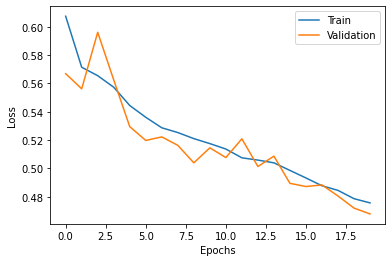

In [146]:
epochs = [i for i in range(20)]
train = [( metrics[0][i]["Average Loss"]  ) for i in metrics[0]]
val = [( metrics[1][i]["Average Loss"]  ) for i in metrics[0]]
plt.plot(epochs, train, label = "Train")
plt.plot(epochs, val, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [201]:
#Trained Model 
model = getModel()
model.load_state_dict(torch.load("/content/drive/My Drive/Untitled folder/NonPreTrained.pth"))

<All keys matched successfully>

In [217]:
model.train()
optimizer = torch.optim.Adam(model.to(device).parameters())
metrics = test(model, test_loader, device)

Batch in Progress: 100%|██████████████████████████████████████████| 478/478 [01:04<00:00,  7.38it/s]

prec 401.03459295038607


In [218]:
metrics

{'Accuracy': 0.7765136654897346,
 'Average Loss': 14.874454514252092,
 'Correct': 11876,
 'Precision': 0.8389845040803056,
 'Recall': 0.7163730877286565,
 'Size': 15294}

In [150]:
#torch.save(model.state_dict(), "/content/drive/My Drive/Untitled folder/NonPreTrained.pth")

In [225]:
# Resnet18
net = resnet18(pretrained = True)

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 1)

In [152]:
test_abs = int(len(train_set) * 0.8)
train_subset, val_subset = random_split(
train_set, [test_abs, len(train_set) - test_abs])

In [71]:
# Train Resnet

epoch = 20
device = 'cuda'

optimizer = torch.optim.Adam(net.to(device).parameters())
metrics = train(net, optimizer, train_loader, val_loader, device, epoch)

Beginning Training: 

Epoch 1/20


Batch in Progress:   0%|                                                    | 0/765 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:19<00:00,  3.84it/s]


Train Set: 
Loss: 0.441404, Accuracy: 79.03%, Correct Counter: 38680/48942, Precision: 82.47%, Recall:  77.00% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:14<00:00,  2.58it/s]


Validation Set: 
Loss: 0.402652, Accuracy: 81.06%, Correct Counter: 9919/12236, Precision: 80.54%, Recall:  84.48% 

Epoch 2/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:18<00:00,  3.86it/s]


Train Set: 
Loss: 0.404588, Accuracy: 81.03%, Correct Counter: 39656/48942, Precision: 84.36%, Recall:  79.10% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:14<00:00,  2.57it/s]


Validation Set: 
Loss: 0.442077, Accuracy: 79.01%, Correct Counter: 9668/12236, Precision: 93.05%, Recall:  64.92% 

Epoch 3/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:21<00:00,  3.80it/s]


Train Set: 
Loss: 0.387044, Accuracy: 81.83%, Correct Counter: 40051/48942, Precision: 85.03%, Recall:  80.02% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:15<00:00,  2.55it/s]


Validation Set: 
Loss: 0.399441, Accuracy: 81.02%, Correct Counter: 9913/12236, Precision: 81.13%, Recall:  83.13% 

Epoch 4/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:20<00:00,  3.82it/s]


Train Set: 
Loss: 0.373469, Accuracy: 82.80%, Correct Counter: 40522/48942, Precision: 85.64%, Recall:  81.35% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:15<00:00,  2.54it/s]


Validation Set: 
Loss: 0.427470, Accuracy: 79.81%, Correct Counter: 9765/12236, Precision: 76.66%, Recall:  88.65% 

Epoch 5/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:24<00:00,  3.74it/s]


Train Set: 
Loss: 0.359067, Accuracy: 83.60%, Correct Counter: 40916/48942, Precision: 86.21%, Recall:  82.33% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:15<00:00,  2.55it/s]


Validation Set: 
Loss: 0.404201, Accuracy: 80.16%, Correct Counter: 9808/12236, Precision: 77.42%, Recall:  87.99% 

Epoch 6/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:21<00:00,  3.80it/s]


Train Set: 
Loss: 0.332148, Accuracy: 84.98%, Correct Counter: 41592/48942, Precision: 87.23%, Recall:  84.10% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:14<00:00,  2.59it/s]


Validation Set: 
Loss: 0.391558, Accuracy: 82.10%, Correct Counter: 10046/12236, Precision: 86.57%, Recall:  78.03% 

Epoch 7/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:22<00:00,  3.78it/s]


Train Set: 
Loss: 0.284492, Accuracy: 87.42%, Correct Counter: 42785/48942, Precision: 88.97%, Recall:  87.24% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:14<00:00,  2.59it/s]


Validation Set: 
Loss: 0.437009, Accuracy: 80.13%, Correct Counter: 9805/12236, Precision: 83.53%, Recall:  77.52% 

Epoch 8/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:19<00:00,  3.83it/s]


Train Set: 
Loss: 0.197701, Accuracy: 91.82%, Correct Counter: 44940/48942, Precision: 92.40%, Recall:  92.23% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:14<00:00,  2.59it/s]


Validation Set: 
Loss: 0.514909, Accuracy: 78.89%, Correct Counter: 9653/12236, Precision: 78.08%, Recall:  83.34% 

Epoch 9/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:19<00:00,  3.83it/s]


Train Set: 
Loss: 0.120747, Accuracy: 95.25%, Correct Counter: 46616/48942, Precision: 95.45%, Recall:  95.66% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:14<00:00,  2.59it/s]


Validation Set: 
Loss: 0.666588, Accuracy: 80.00%, Correct Counter: 9789/12236, Precision: 81.30%, Recall:  80.52% 

Epoch 10/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:19<00:00,  3.83it/s]


Train Set: 
Loss: 0.079962, Accuracy: 96.96%, Correct Counter: 47453/48942, Precision: 96.96%, Recall:  97.31% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:13<00:00,  2.60it/s]


Validation Set: 
Loss: 0.678245, Accuracy: 79.05%, Correct Counter: 9672/12236, Precision: 81.78%, Recall:  77.54% 

Epoch 11/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:19<00:00,  3.84it/s]


Train Set: 
Loss: 0.055957, Accuracy: 98.00%, Correct Counter: 47965/48942, Precision: 98.01%, Recall:  98.22% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:14<00:00,  2.57it/s]


Validation Set: 
Loss: 0.854216, Accuracy: 79.41%, Correct Counter: 9717/12236, Precision: 81.14%, Recall:  79.60% 

Epoch 12/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:22<00:00,  3.77it/s]


Train Set: 
Loss: 0.049577, Accuracy: 98.13%, Correct Counter: 48029/48942, Precision: 98.12%, Recall:  98.36% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:15<00:00,  2.54it/s]


Validation Set: 
Loss: 0.985830, Accuracy: 79.39%, Correct Counter: 9714/12236, Precision: 82.99%, Recall:  76.67% 

Epoch 13/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:24<00:00,  3.73it/s]


Train Set: 
Loss: 0.042743, Accuracy: 98.44%, Correct Counter: 48179/48942, Precision: 98.45%, Recall:  98.62% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:16<00:00,  2.53it/s]


Validation Set: 
Loss: 0.960125, Accuracy: 79.09%, Correct Counter: 9677/12236, Precision: 79.53%, Recall:  81.34% 

Epoch 14/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:26<00:00,  3.71it/s]


Train Set: 
Loss: 0.040023, Accuracy: 98.55%, Correct Counter: 48232/48942, Precision: 98.59%, Recall:  98.68% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:16<00:00,  2.52it/s]


Validation Set: 
Loss: 1.040565, Accuracy: 79.78%, Correct Counter: 9762/12236, Precision: 83.14%, Recall:  77.15% 

Epoch 15/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:25<00:00,  3.72it/s]


Train Set: 
Loss: 0.035057, Accuracy: 98.72%, Correct Counter: 48316/48942, Precision: 98.72%, Recall:  98.84% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:15<00:00,  2.53it/s]


Validation Set: 
Loss: 1.085368, Accuracy: 78.72%, Correct Counter: 9632/12236, Precision: 79.48%, Recall:  80.39% 

Epoch 16/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:26<00:00,  3.71it/s]


Train Set: 
Loss: 0.034219, Accuracy: 98.77%, Correct Counter: 48338/48942, Precision: 98.77%, Recall:  98.89% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:14<00:00,  2.56it/s]


Validation Set: 
Loss: 0.974616, Accuracy: 78.50%, Correct Counter: 9605/12236, Precision: 82.52%, Recall:  75.14% 

Epoch 17/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:25<00:00,  3.72it/s]


Train Set: 
Loss: 0.030586, Accuracy: 98.91%, Correct Counter: 48409/48942, Precision: 98.91%, Recall:  99.01% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:16<00:00,  2.52it/s]


Validation Set: 
Loss: 1.073432, Accuracy: 76.54%, Correct Counter: 9365/12236, Precision: 80.63%, Recall:  73.02% 

Epoch 18/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:25<00:00,  3.73it/s]


Train Set: 
Loss: 0.029276, Accuracy: 98.93%, Correct Counter: 48417/48942, Precision: 98.93%, Recall:  99.03% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:16<00:00,  2.52it/s]


Validation Set: 
Loss: 1.149651, Accuracy: 78.85%, Correct Counter: 9648/12236, Precision: 84.39%, Recall:  73.50% 

Epoch 19/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:27<00:00,  3.69it/s]


Train Set: 
Loss: 0.027443, Accuracy: 99.02%, Correct Counter: 48461/48942, Precision: 99.04%, Recall:  99.09% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:15<00:00,  2.53it/s]


Validation Set: 
Loss: 1.103642, Accuracy: 77.84%, Correct Counter: 9524/12236, Precision: 75.65%, Recall:  85.30% 

Epoch 20/20


Batch in Progress: 100%|██████████████████████████████████████████| 765/765 [03:24<00:00,  3.74it/s]


Train Set: 
Loss: 0.027006, Accuracy: 99.02%, Correct Counter: 48460/48942, Precision: 99.02%, Recall:  99.13% 



Batch in Progress: 100%|██████████████████████████████████████████| 192/192 [01:16<00:00,  2.52it/s]

Validation Set: 
Loss: 1.036054, Accuracy: 77.64%, Correct Counter: 9500/12236, Precision: 78.81%, Recall:  78.75% 

Train Metrics:  {1: {'Average Loss': 21603.189453125, 'Correct': 38680, 'Accuracy': 0.7903232397531772, 'Precision': 0.8246918169968467, 'Recall': 0.7700030289818087, 'Size': 48942}, 2: {'Average Loss': 19801.33203125, 'Correct': 39656, 'Accuracy': 0.8102652118834539, 'Precision': 0.8435654010313657, 'Recall': 0.7909830678521437, 'Size': 48942}, 3: {'Average Loss': 18942.724609375, 'Correct': 40051, 'Accuracy': 0.8183359895386376, 'Precision': 0.8502880173384535, 'Recall': 0.8002410356561513, 'Size': 48942}, 4: {'Average Loss': 18278.322265625, 'Correct': 40522, 'Accuracy': 0.8279596256793755, 'Precision': 0.8563855902033886, 'Recall': 0.81350343354764, 'Size': 48942}, 5: {'Average Loss': 17573.4609375, 'Correct': 40916, 'Accuracy': 0.8360099709860651, 'Precision': 0.8621105777324984, 'Recall': 0.8232513259882775, 'Size': 48942}, 6: {'Average Loss': 16256.001953125, 'Cor

In [226]:
net.load_state_dict(torch.load("/content/drive/My Drive/Untitled folder/resnetCNN.pth"))

<All keys matched successfully>

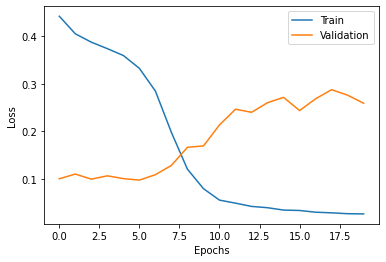

In [115]:
epochs = [i for i in range(20)]
train = [( metrics[0][i]["Average Loss"] / metrics[0][1]["Size"] ) for i in metrics[0]]
val = [( metrics[1][i]["Average Loss"] / metrics[0][1]["Size"] ) for i in metrics[0]]
plt.plot(epochs, train, label = "Train")
plt.plot(epochs, val, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [228]:
net = net.cuda()
net = net.eval()
metrics_test = test(net, test_loader, device)

Batch in Progress: 100%|██████████████████████████████████████████| 478/478 [01:02<00:00,  7.70it/s]

prec 379.6986965977444


In [229]:
metrics_test

{'Accuracy': 0.7784098339217994,
 'Average Loss': 33.70775447829498,
 'Correct': 11905,
 'Precision': 0.7943487376521849,
 'Recall': 0.7887878828833395,
 'Size': 15294}

In [ ]:
from torch import nn
import torch.nn.functional as F

def train_cifar(config, checkpoint_dir=None, data_dir=None):

  device = 'cuda'

  model = getModel()
  
  optimizer = torch.optim.Adam(model.to(device).parameters(), lr=config["lr"])

  trainset, testsest = load_data()
  test_abs = int(len(trainset) * 0.8)
  train_subset, val_subset = random_split(
    trainset, [test_abs, len(trainset) - test_abs])

  trainloader = torch.utils.data.DataLoader(
      train_subset,
      batch_size=int(config["batch_size"]),
      #batch_size = 64,
      shuffle=True,
      num_workers=2)
  valloader = torch.utils.data.DataLoader(
      val_subset,
      batch_size=int(config["batch_size"]),
      #batch_size = 64,
      shuffle=True,
      num_workers=2)
  
  for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)


      logits = model(inputs)
      labels = labels.float()
      loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1))
      
      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      epoch_steps += 1
      if i % 2000 == 1999:  # print every 2000 mini-batches
        print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                        running_loss / epoch_steps))
        running_loss = 0.0

      val_loss = 0.0
      val_steps = 0
      total = 0
      correct = 0
      for i, data in enumerate(valloader, 0):
        with torch.no_grad():
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          labels = labels.float()

          logits = model(inputs)
          total += labels.size(0)
          sig = map(binary_logits_prediction, logits.to('cpu').detach())
          sig = torch.tensor(list(sig), device = device)
          correct += (sig == labels).sum()

          # _, predicted = torch.max(outputs.data, 1)
          # total += labels.size(0)
          # correct += (predicted == labels).sum().item()

          loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1))
          val_loss += loss.cpu().numpy()
          val_steps += 1

    tune.report(loss=(val_loss / val_steps), accuracy=correct / total)


In [ ]:
# RayTune Optimization

config = {
  "lr": tune.loguniform(0.0001, 0.1),
  "batch_size": tune.choice([2, 4, 8, 16, 32, 64])
}
scheduler = ASHAScheduler(
  metric="loss",
  mode="min",
  max_t=10,
  grace_period=1,
  reduction_factor=2)
reporter = CLIReporter (
  # parameter_columns=["l1", "l2", "lr", "batch_size"],
  metric_columns=["loss", "accuracy", "training_iteration"])

result = tune.run(
  partial(train_cifar),
  resources_per_trial={"cpu": 1, "gpu": 1},
  config=config,
  num_samples=10,
  scheduler=scheduler,
  progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
best_trial.last_result["accuracy"]))